## Rotation of a blob of heat

### How much heat is lost after a single rotation

Solving advection diffusion equation in a velocity field of unit angular velocity

Domain [-0.5,0.5]x[-0.5,0.5]

#### Temperature conditions

T(x,0) = 0.25 * (1+cos(pi*X)) * (1+cos(pi*Y)) if x^2+y^2 <= 1
         else 0
         
[X, Y] = [(x-x_0)/sigma , (x-x_1)/sigma]

T = 0 on all boundaries

#### Velocity conditions

V(x) = (-x_1, x_0)


In [1]:
sigma = 0.2
x_0 = (1./6, 1./6)
diffusion = 1e-6

method_setup = 'slcn'
# method_setup = 'supg'

In [2]:
import underworld as uw
import underworld.function as fn
import glucifer
import numpy as np

In [3]:
mesh = uw.mesh.FeMesh_Cartesian(elementType='Q1', 
                                elementRes=(30,30),
                                minCoord  = (-0.5,-0.5),
                                maxCoord  = (0.5,0.5) )

tField = mesh.add_variable(1)
tStarField = mesh.add_variable(1)
vField = mesh.add_variable(2)
 
all_walls = mesh.specialSets["AllWalls_VertexSet"]

In [4]:
fig = glucifer.Figure()
fig.VectorArrows(mesh,vField)
fig.Surface(mesh,tField, valueRange=[0.,1.]);

In [5]:
# functions to define the cosine hill
fn_X = (fn.input()[0]-x_0[0])/sigma
fn_Y = (fn.input()[1]-x_0[1])/sigma

fn_inside = ( fn.math.pow(fn_X,2.) + fn.math.pow(fn_Y,2.) ) < 1.

fn_hill   = 0.25 * ( 1.+fn.math.cos(np.pi*fn_X) ) * ( 1.+fn.math.cos(np.pi*fn_Y) )

# if inside condition fn_inside set with fn_hill, else set to 0
fn_ic = fn.branching.conditional([(fn_inside, fn_hill ), 
                                  (True     , 0.)])

In [6]:
# tField.data[:] = hill(mesh.data[:,0], mesh.data[:,1])
tField.data[:] = fn_ic.evaluate(mesh)

In [7]:
x_vel = -1.*uw.function.coord()[1]
y_vel = 1.*uw.function.coord()[0]

vField.data[:,0]=x_vel.evaluate(mesh).reshape(-1)
vField.data[:,1]=y_vel.evaluate(mesh).reshape(-1)

fn_K = uw.function.misc.constant(diffusion)

# timestep implementation - not the best
dt = 2*np.pi/200 # as per benchmark

print dt

0.0314159265359



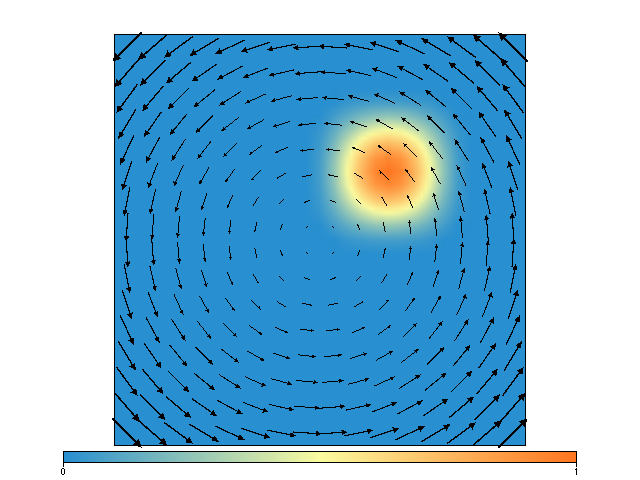

In [8]:
fig.show()

In [9]:
measureT = fn.view.min_max(tField,fn_auxiliary=fn.input())
measureT.evaluate(mesh);
intT,vol = mesh.integrate(fn=(tField,1.))
print("The max temperature {0:.3f} and the volume avg. temperture {1:0.3f}".format(measureT.max_global(), intT/vol))

The max temperature 1.000 and the volume avg. temperture 0.040


In [10]:
dbc = uw.conditions.DirichletCondition(variable=tField,
                                       indexSetsPerDof=all_walls)

In [11]:
# define heat eq. system
if method_setup == 'supg':
    tDotField = mesh.add_variable( nodeDofCount=1, dataType='double') # extra variable needed with supg
    system = uw.systems.AdvectionDiffusion( phiField       = tField,
                                            phiDotField    = tDotField,
                                            velocityField  = vField,
                                            fn_diffusivity = fn_K,
                                            conditions     = [dbc] )
else:
    system = uw.systems.SLCN_AdvectionDiffusion( phiField       = tField,
                                                 velocityField  = vField, 
                                                 fn_diffusivity = fn_K,
                                                 conditions     = [dbc])

In [12]:
time = 0
steps = 0

while time<2.*np.pi:

    system.integrate(dt)
    
    time  += dt
    steps += 1


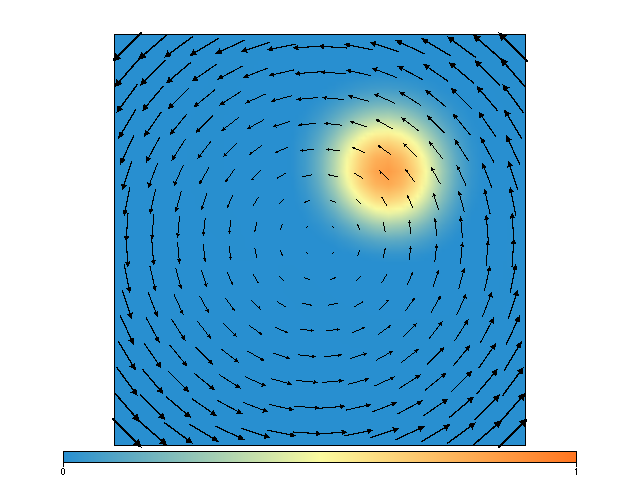

In [13]:
fig.show()

In [14]:
measureT = fn.view.min_max(tField,fn_auxiliary=fn.input())
measureT.evaluate(mesh);
intT,vol = mesh.integrate(fn=(tField,1.))
print("The max temperature {0:.3f} and the volume avg. temperture {1:0.3f}".format(measureT.max_global(), intT/vol))

The max temperature 0.851 and the volume avg. temperture 0.040


In [15]:
# 0.8511144231858909
# 0.04007998678062034